# Images preprocessing
This notebook includes scripts to preprocess training images.

## Explore the data
In this section, we will explore the data and see if we can find any interesting patterns.

In [31]:
import glob
import random

import matplotlib.pyplot as plt

In [32]:
def get_classes():
    '''
    Returns a list of classes
    '''
    classes_file = open('../data/raw/names.txt', 'r')
    classes = [line.strip()[4:] for line in classes_file] 
    return classes

In [33]:
print(get_classes())

['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']


In [34]:
def load_classes_data_paths(images_dir):
    '''
    Loads images paths for each class.
    '''
    classes = get_classes()
    images = dict()

    for idx, class_name in enumerate(classes):
        images[class_name] = glob.glob(images_dir + str(idx + 1) + '/*.jpg')
        
    return images

In [35]:
def get_random_classes_images(classes_images, n_images):
    '''
    Returns a list of random images from each class.
    '''
    
    random_images = dict()
    for class_name, images in classes_images.items():
        random_images[class_name] = random.sample(images, n_images)
    return random_images
    

In [36]:
def show_classes_images(classes_images):
    '''
    Shows images from each class.
    '''

    for class_name in classes_images.keys():
        fig = plt.figure(figsize=(25, 20))
        columns = len(classes_images[class_name])
        
        for idx, image_path in enumerate(classes_images[class_name]):
            image = plt.imread(image_path)
            fig.add_subplot(1, columns, idx + 1)
            plt.imshow(image)
            plt.title(class_name + ': ' + image_path)

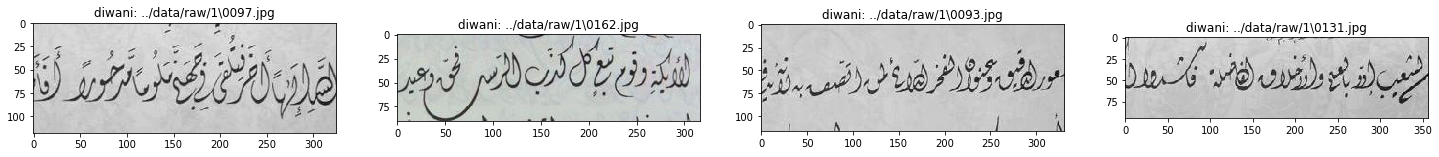

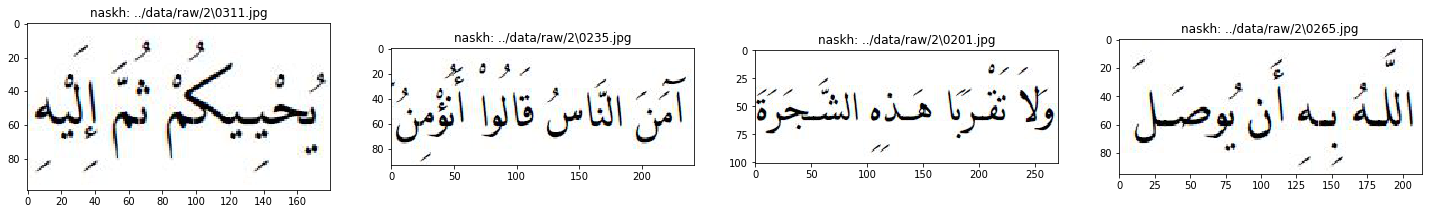

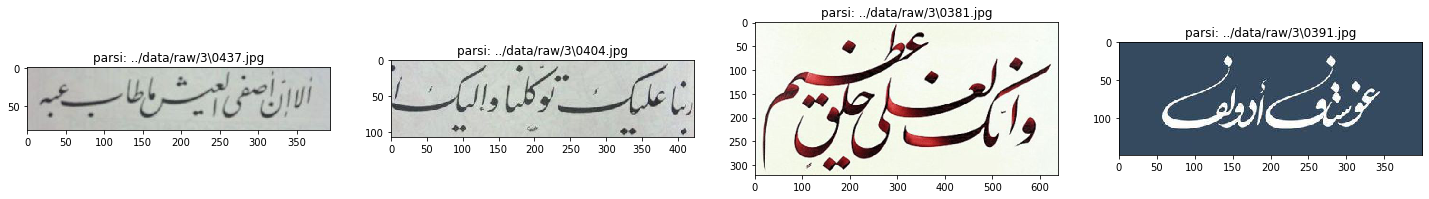

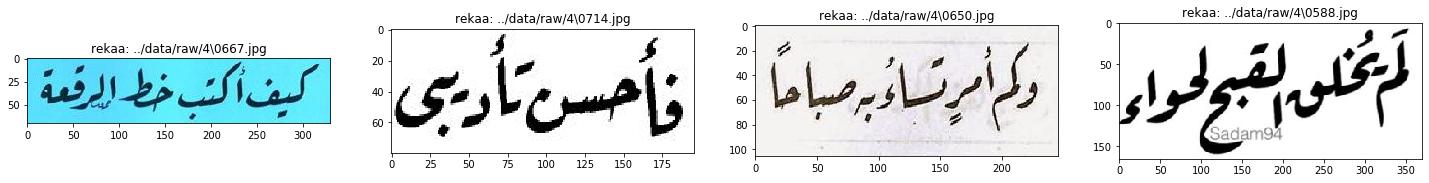

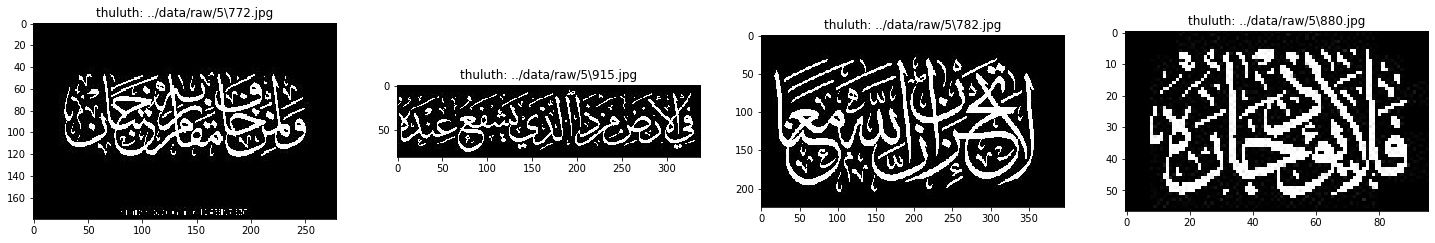

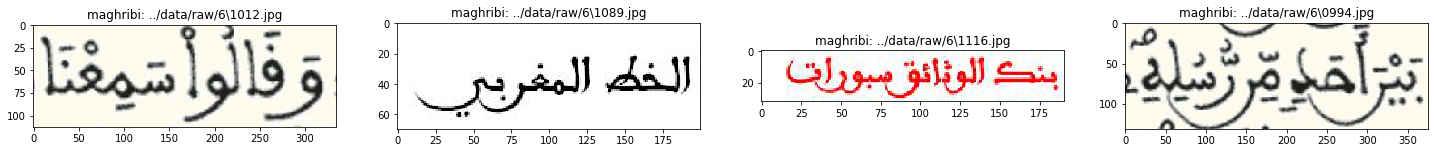

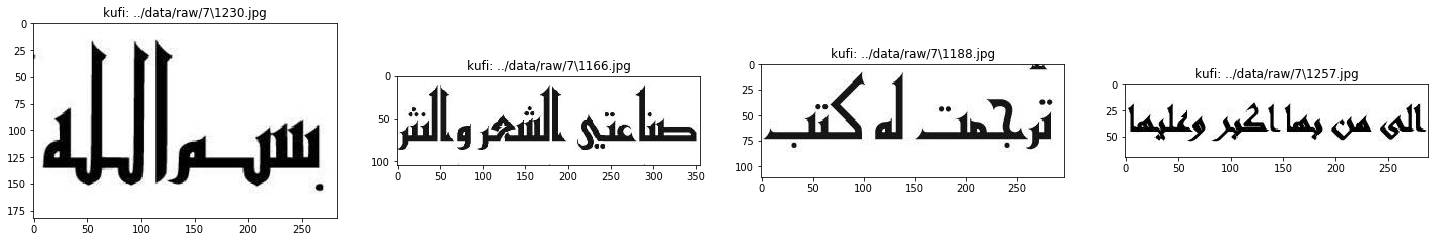

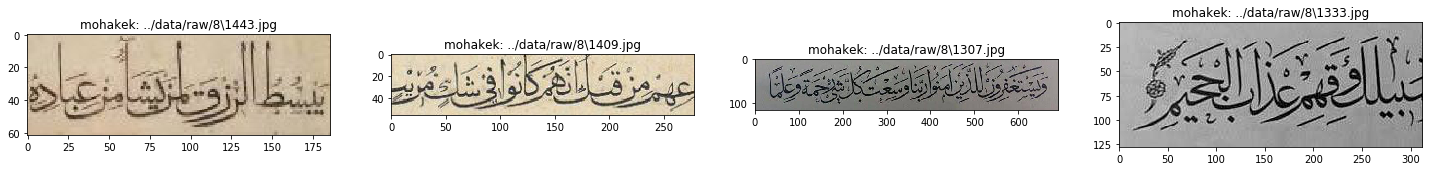

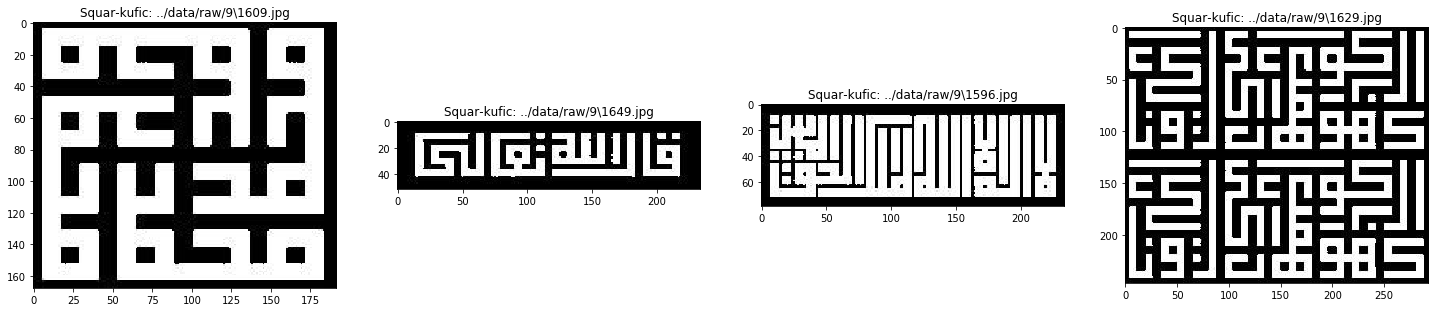

In [37]:
# get classes images
classes_images = load_classes_data_paths('../data/raw/')

# plot random images from each class
n_random_images = 4
random_images = get_random_classes_images(classes_images, n_random_images)
show_classes_images(random_images)

### Notes
* We can see that the images are not all the same size.
* All the images seem to have a bimodal histogram; thus a simple thresholding could be used to remove the background.

## Preprocess images
In this section, we will preprocess the images to make them ready for training.

In [38]:
import skimage.io as io
import numpy as np

from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

from utils import show_images

In [39]:
def apply_thresholding(image):
    gray_scale_image = rgb2gray(image)
    return gray_scale_image > threshold_otsu(gray_scale_image)

In [40]:
def show_classes_images_w_transformation(classes_images, transform_func):
    '''
    Shows images from each class before and after transformation.
    '''
    
    for class_name, class_images in classes_images.items():
        images = [io.imread(img) for img in class_images]
        transformed_images = [transform_func(img) for img in images]
        
        show_images([images[0], transformed_images[0], 
                     images[1], transformed_images[1]],
                    [class_name + '1', class_name + '1-binary', 
                     class_name + '2', class_name + '2-binary'])
        
        show_images([images[2], transformed_images[2], 
                     images[3], transformed_images[3]],
                    [class_name + '3', class_name + '3-binary', 
                     class_name + '4', class_name + '4-binary'])


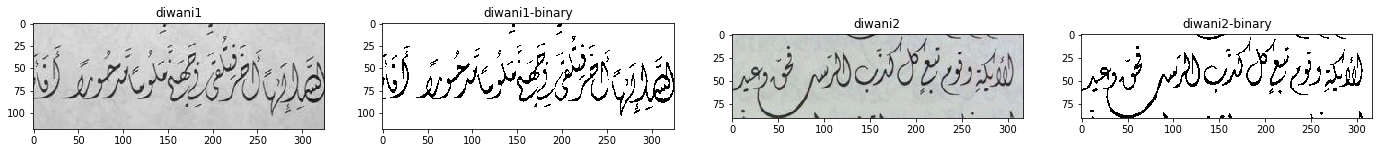

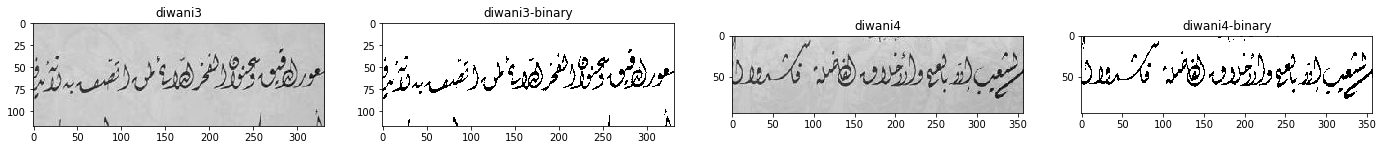

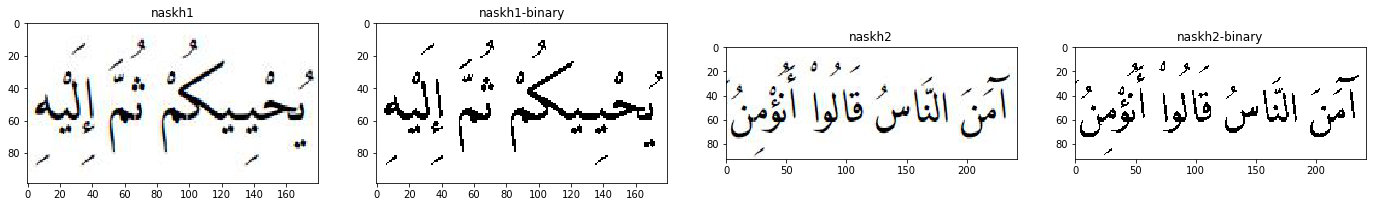

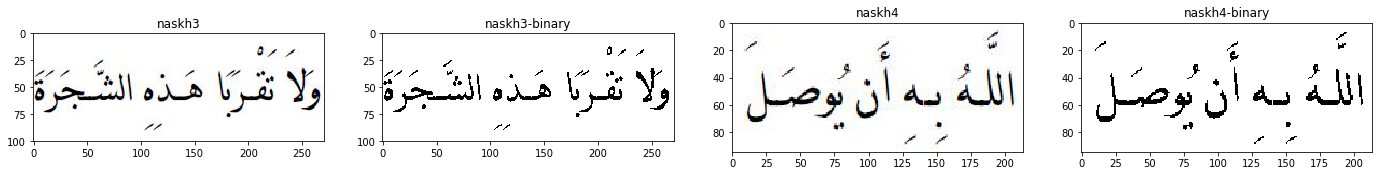

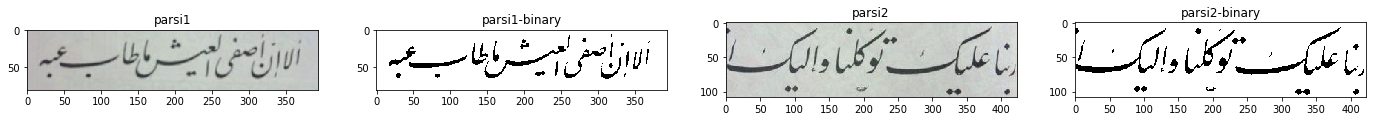

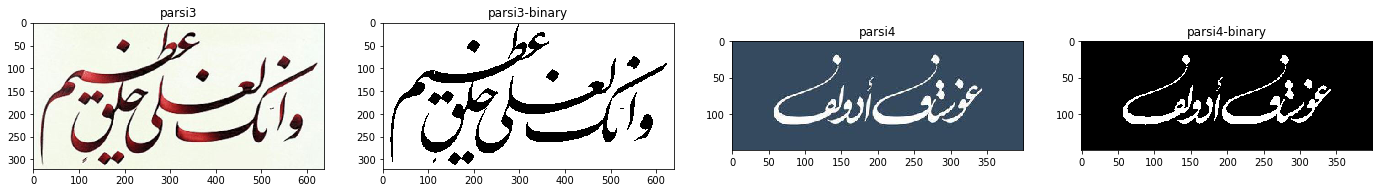

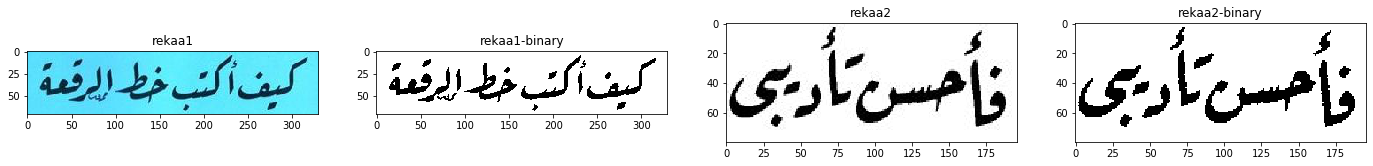

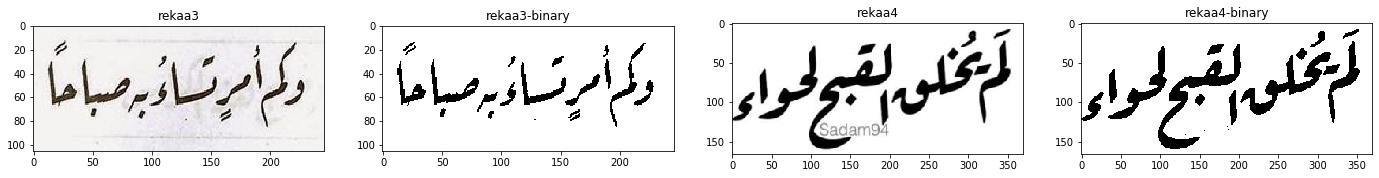

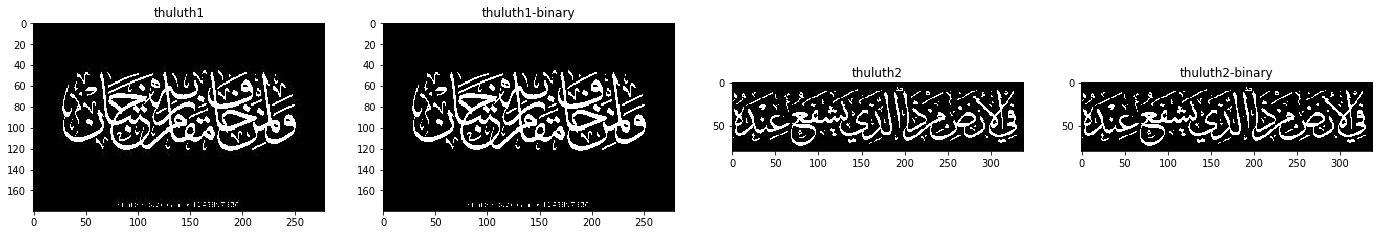

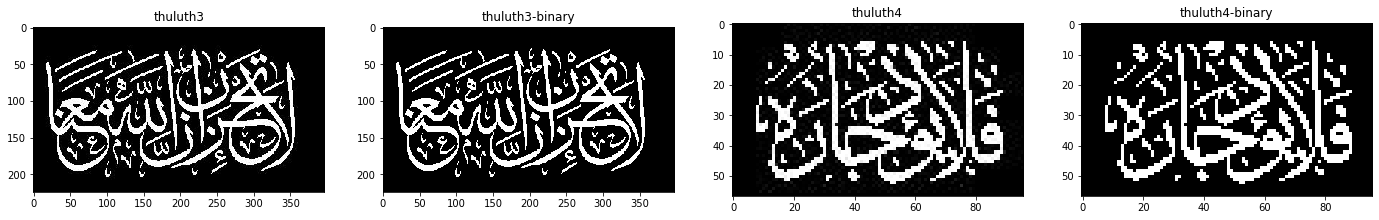

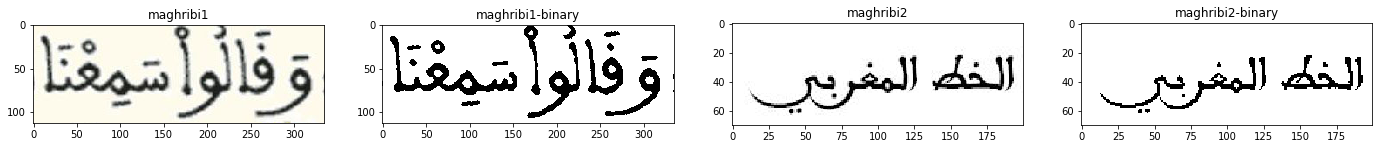

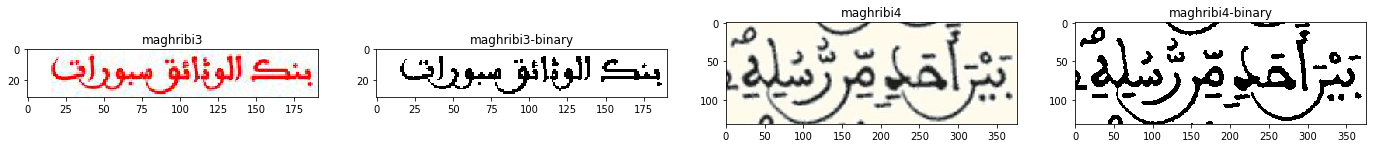

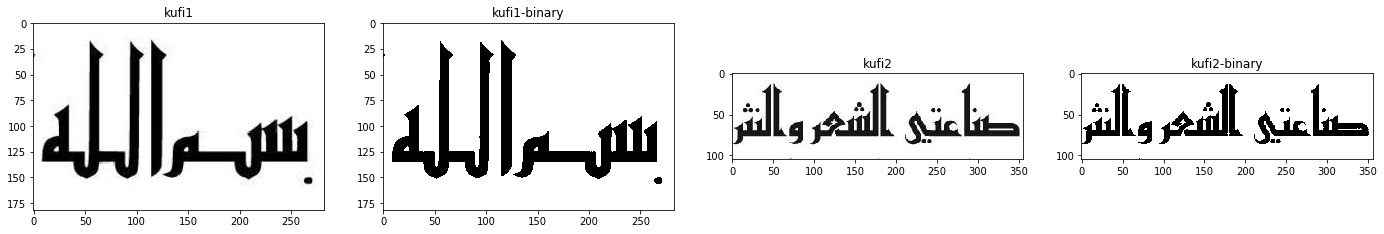

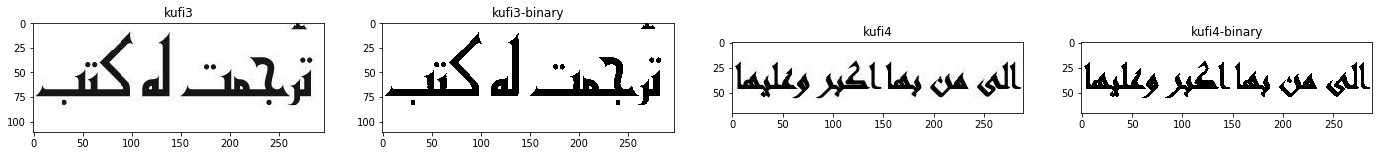

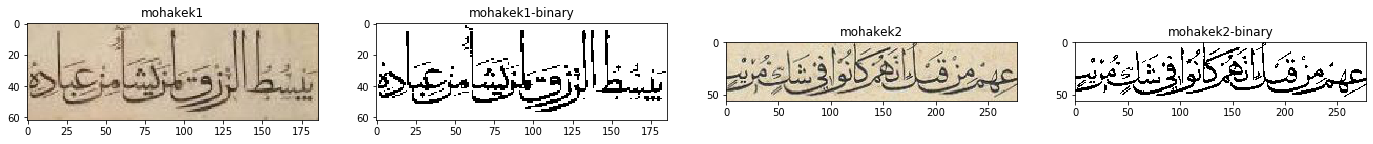

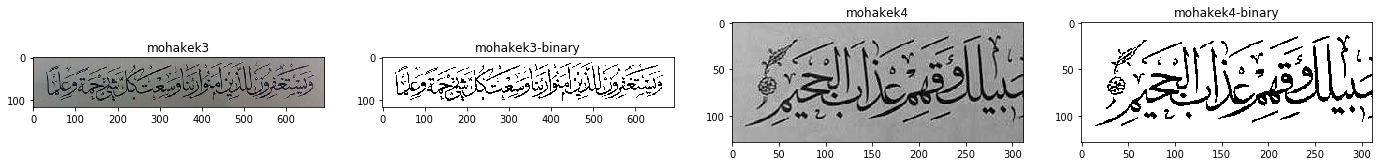

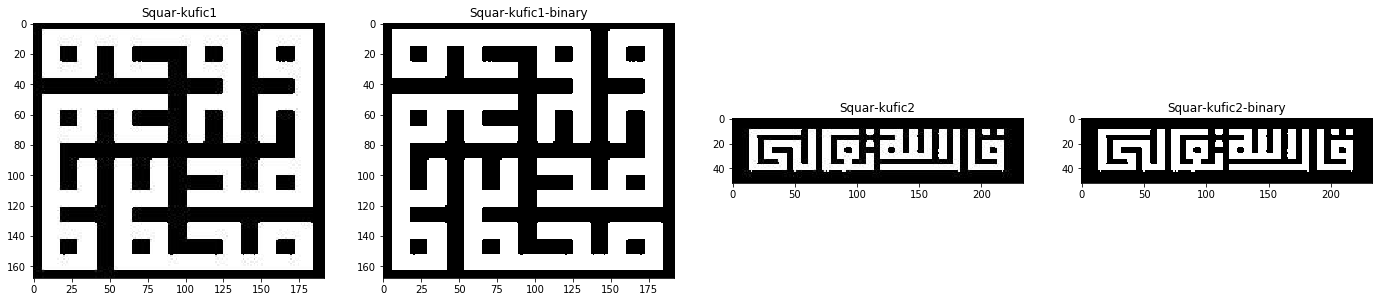

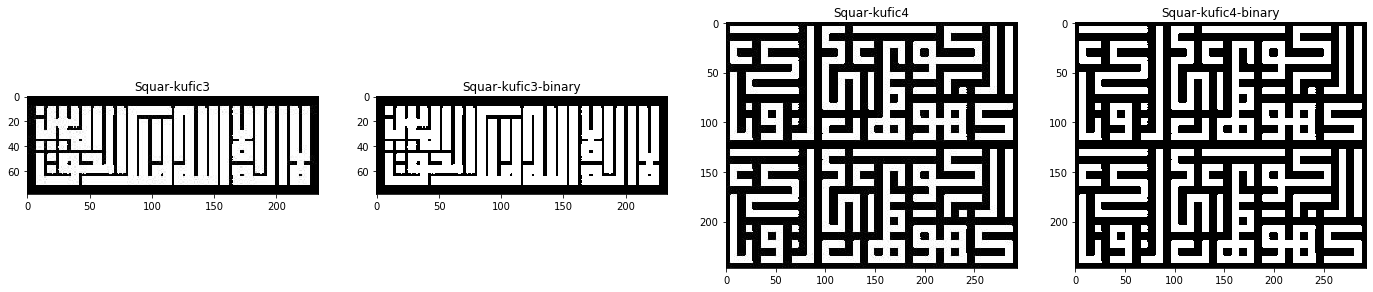

In [41]:
show_classes_images_w_transformation(random_images, apply_thresholding)

**Note** we can check the four corners colors to determine if the binary photo colors should be inverted. This could be done so that all text be white on black background.

In [42]:
def apply_thresholding_w_color_correction(image):
    '''
    Applies thresholding and color correction to the image.
    '''
    gray_scale_image = rgb2gray(image)
    binary_image = gray_scale_image > threshold_otsu(gray_scale_image)
    
    rows, columns = binary_image.shape
    rows -= 1
    columns -= 1
    
    corners = [binary_image[0,0], binary_image[0, columns], 
               binary_image[rows, 0], binary_image[rows, columns]]
    
    if np.argmax(np.bincount(corners)) == 1:
        binary_image = np.invert(binary_image)
    
    return binary_image

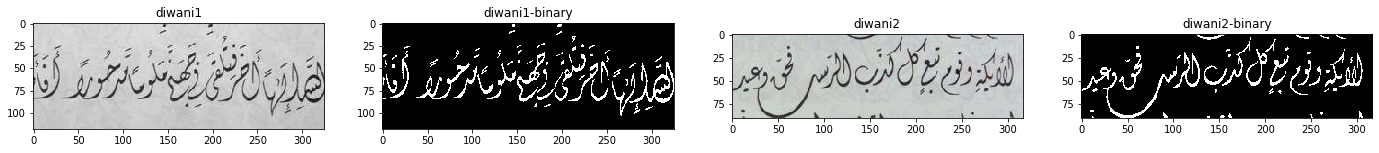

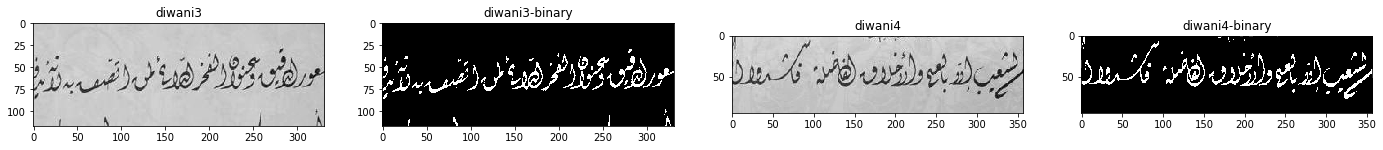

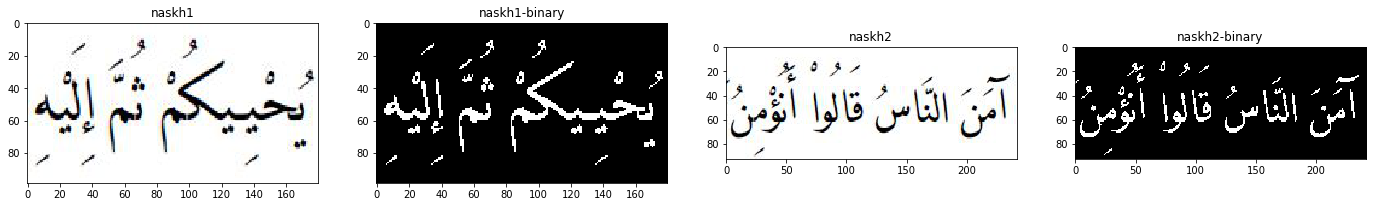

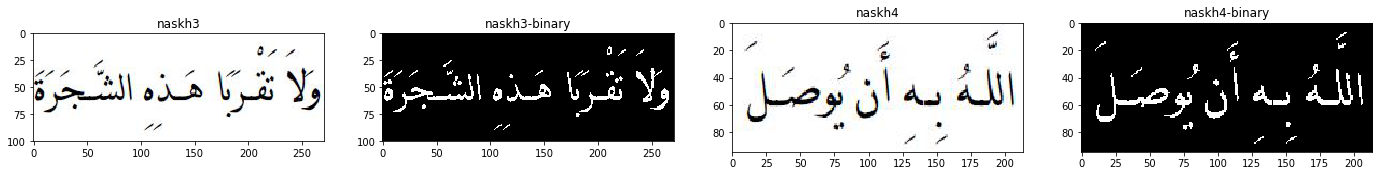

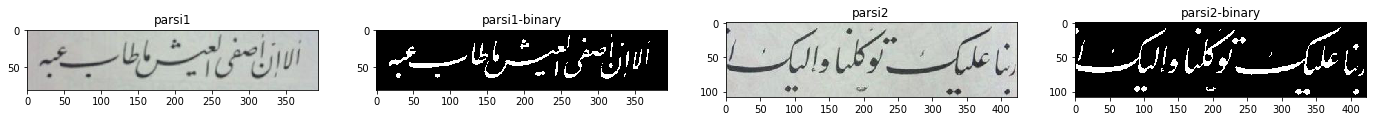

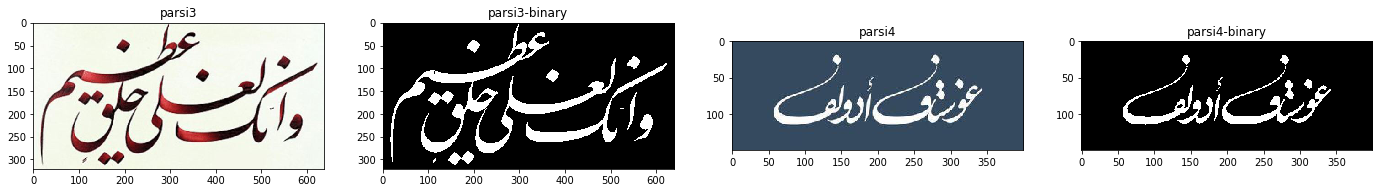

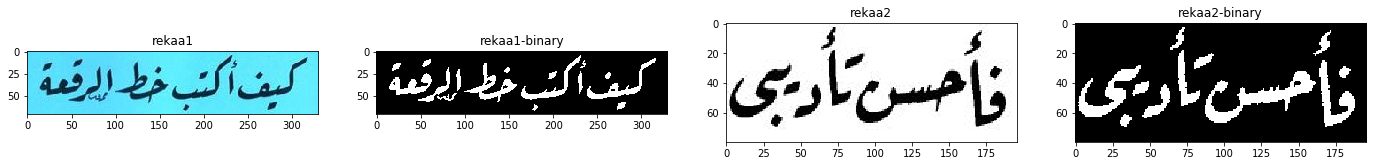

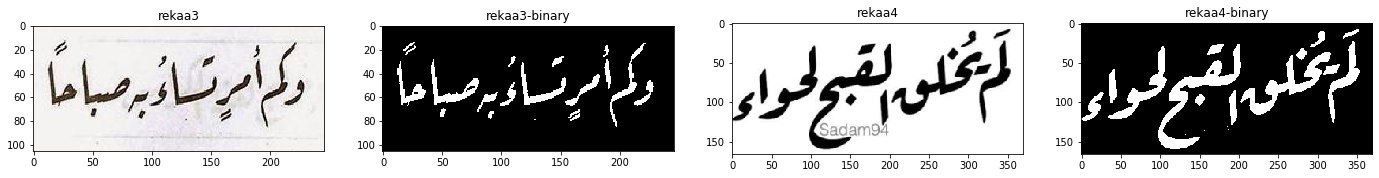

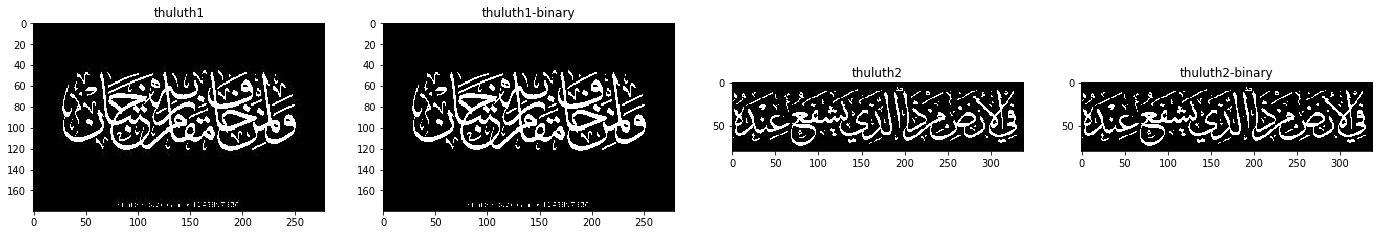

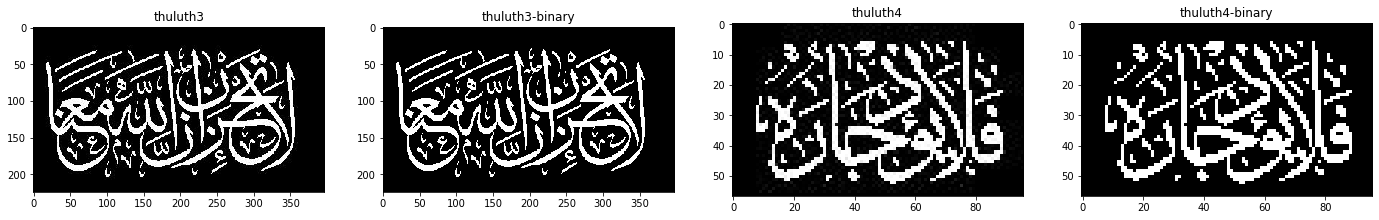

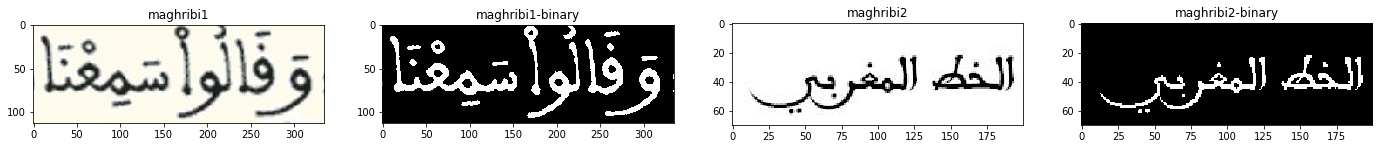

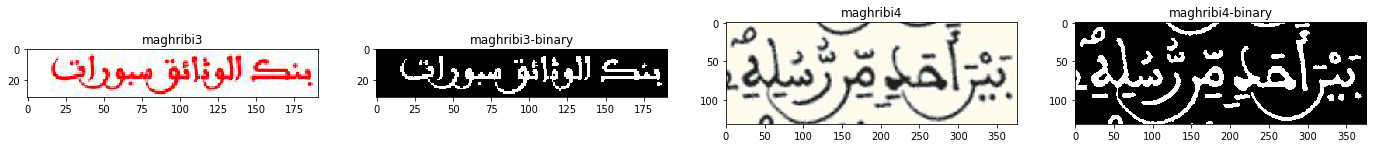

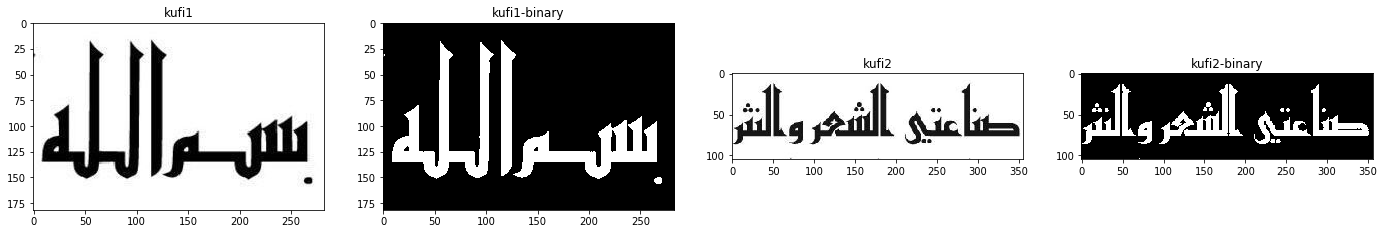

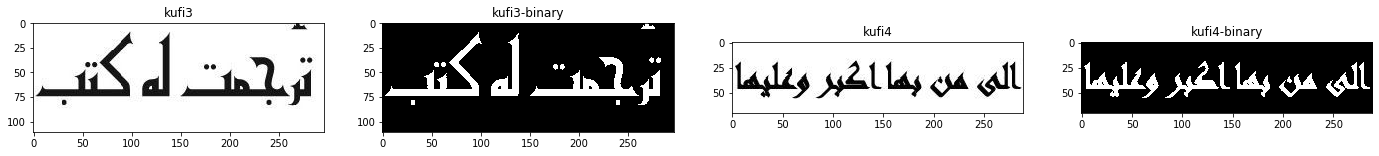

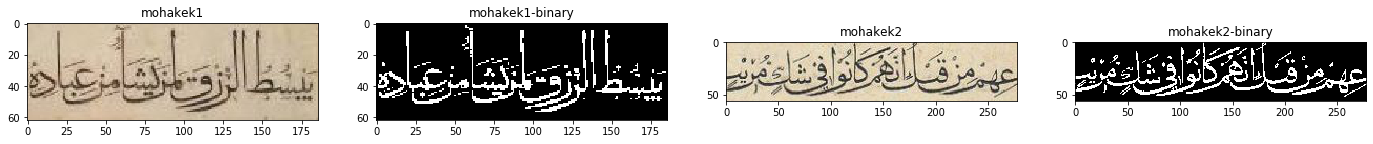

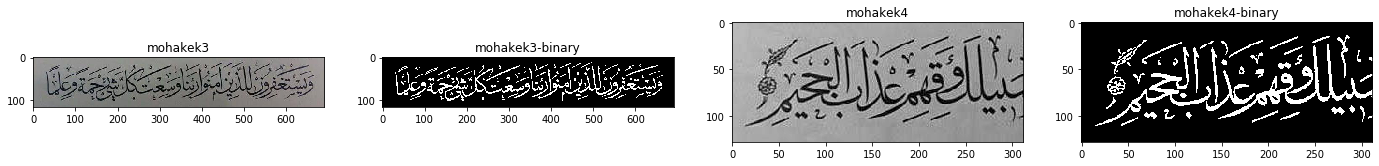

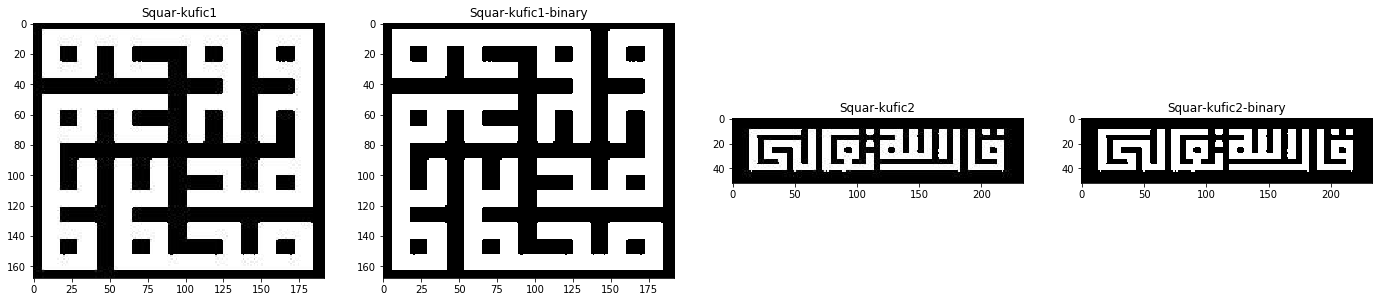

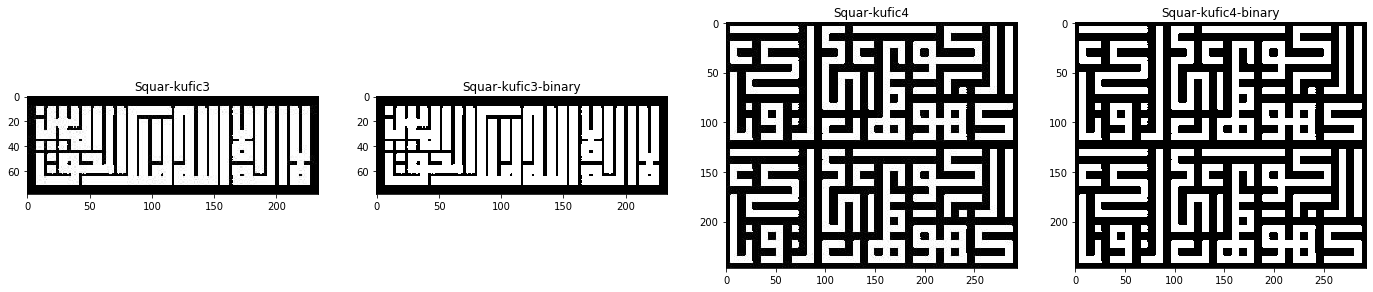

In [43]:
show_classes_images_w_transformation(random_images, apply_thresholding_w_color_correction)

**Notes:** 
- For now this output seems good enough.
- It may need to be smoothed to remove noise.

## Data splitting
In this section, we will split the data into training and validation sets.

In [44]:
def split_train_test_validation_sets(classes_images, train_ratio, validation_ratio):
    '''
    Splits images into train, test and validation sets.
    '''
    train_images = dict()
    test_images = dict()
    validation_images = dict()
    
    for class_name, class_images in classes_images.items():
        n_images = len(class_images)
        n_train_images = int(n_images * train_ratio)
        n_validation_images = int(n_images * validation_ratio)
        
        train_images[class_name] = class_images[:n_train_images]
        test_images[class_name] = class_images[n_train_images:n_train_images + n_validation_images]
        validation_images[class_name] = class_images[n_train_images + n_validation_images:]
        
    return train_images, test_images, validation_images

## Saving data
In this section, we will save the processed images to a directory.

In [45]:
import os
from skimage import img_as_ubyte

In [46]:
def save_preprocessed_images(images_dir, classes_images, transform_func):
    '''
    Saves preprocessed images to the disk.
    '''
    for idx, class_images in enumerate(classes_images.values()):
        dir_name = images_dir + str(idx + 1)
        
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        else:
            raise Exception('Directory already exists')
        
        for image_path in class_images:
            image = io.imread(image_path)
            transformed_image = transform_func(image)

            image_name = image_path.split('\\')[-1]
            
            io.imsave(dir_name + '/' + image_name, img_as_ubyte(transformed_image))

## Preprocessing pipeline
load images --> split into train, test and validation sets --> preprocess images --> save to disk

In [48]:
classes = get_classes()
classes_images = load_classes_data_paths('../data/raw/')
train, test, validation = split_train_test_validation_sets(classes_images, 0.7, 0.2)

save_preprocessed_images('../data/processed/train/', train, apply_thresholding_w_color_correction)
save_preprocessed_images('../data/processed/test/', test, apply_thresholding_w_color_correction)
save_preprocessed_images('../data/processed/validation/', validation, apply_thresholding_w_color_correction)

classes_images_train = load_classes_data_paths('../data/processed/train/')
classes_images_test = load_classes_data_paths('../data/processed/test/')
classes_images_validation = load_classes_data_paths('../data/processed/validation/')